# Validation: POD class

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import podpy

import warnings
warnings.simplefilter('ignore')

In [16]:
Ndof  = 400
Nsnap = 200
np.random.seed(12)

# --- Setting a relevant snapshot set
tmp = (np.random.rand(Ndof, Nsnap) + 0.5) ** 2
Q = np.linalg.svd(tmp, full_matrices=False)
S = np.diag( np.logspace(1,-16, Ndof)[np.random.permutation(np.arange(Ndof))[:Nsnap]] )
A = Q[0] @ S @ Q[2]


# --- Setting inner product
Xh = np.random.rand(Ndof, Ndof) * 0.3
Xh = (Xh @ Xh.T) + 3*np.eye(Ndof)
if False:
    for i in range(A.shape[1]):
        A[:,i] /= np.sqrt( A[:,i] @ ( Xh @ A[:,i]) )

## Correlation matrix

The $N$-dimensional linear subset $Z_N$ given by the POD algorithm verifies the following optimality criterion
$$
\sum_{k=1}^{K} \| u_k - \pi_{Z_N} u_k \|_{X_h}^2 = \min_{W_N}  \sum_{k=1}^{K} \| u_k - \pi_{W_N} u_k \|_{X_h}^2 = \sum_{i=N+1}^{K} \lambda_i
$$
where $\lambda_K \geq \dots \geq \lambda_1$ are the eigen values of the correlation matrix.

In order to reach a prescribed tolerance in the POD compression, we need to find the smallest $N$ such that $\sum_{i=N+1}^{K} \lambda_i \leq \varepsilon$.
However, to compute this quantity, you need to know the whole spectrum.
To reduce the calculations, we introduce $\lambda_m = \varepsilon / K$ and remark that it exists $I<K$ such that 
$\lambda_m > \lambda_I \geq \lambda_{I+1} \geq \dots \geq \lambda_{K}$ and it follows  
$$
\sum_{i=I}^{K} \lambda_i \leq (K-I) \lambda_m \leq K \lambda_m < \varepsilon.
$$
This implies that $N+1>I$ and that there is no need to compute the eigen values lower than $\lambda_m$.

In [17]:
rb = podpy.POD(A, inner_product=Xh, epsilon=1e-3)
rb.reduce()

36
36


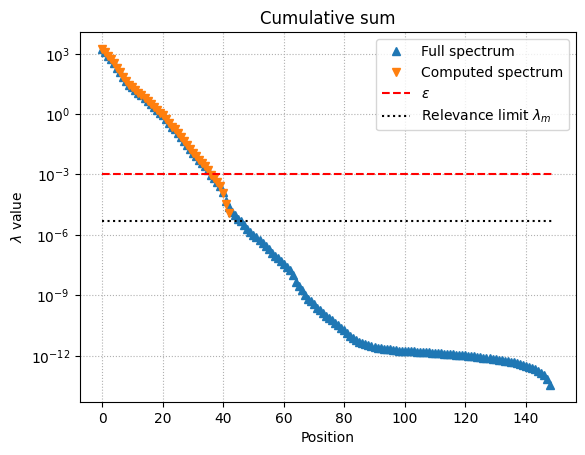

In [18]:
l_min = rb.epsilon / rb.C.shape[0]
S  = sp.linalg.eigvalsh(rb.C, subset_by_value=(np.max([l_min,1e-16]), np.inf) )
Sv = sp.linalg.eigvalsh(rb.C, subset_by_value=(1e-16, np.inf) )

print(np.sum( np.cumsum(Sv) >= rb.epsilon ))
print(np.sum( np.cumsum(S) >= rb.epsilon ))

plt.figure()
plt.semilogy( np.flip(np.cumsum(Sv)) , '^', label='Full spectrum')
plt.semilogy( np.flip(np.cumsum(S)) ,'v', label='Computed spectrum')

plt.semilogy([0, Sv.shape[0]], [rb.epsilon, rb.epsilon], 'r--', label='$\epsilon$')
plt.semilogy([0, Sv.shape[0]], [l_min, l_min], 'k:', label='Relevance limit $\lambda_m$')

plt.title('Cumulative sum')
plt.xlabel('Position')
plt.ylabel('$\lambda$ value')
plt.legend()
plt.grid(linestyle=':')
plt.show()

## Aglorithm validation and error estimate

### Projection error estimate

To provide a crossed validation of the algorithm, we want to use the optimality criterion
$$
\sum_{k=1}^{K} \| u_k - \pi_{Z_N} u_k \|_{X_h}^2 = \sum_{i=N+1}^{K} \lambda_i
$$


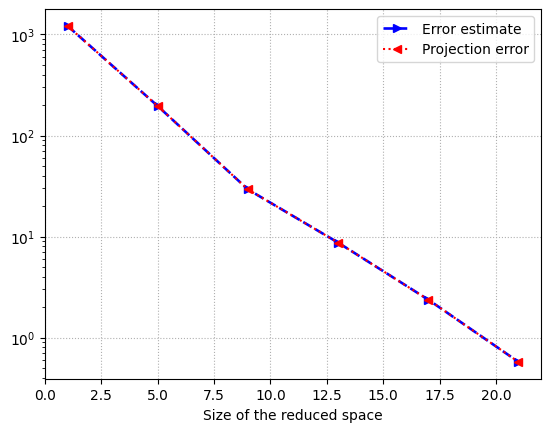

In [19]:
from podpy.pod import projection_error

NN = np.array(np.linspace(1,21,6), dtype='int')
projerr = []
est_err = []

for i in NN:
    # Estimate
    est_err.append( np.sum(Sv[:-i]) )

    # Projection error
    rb = podpy.POD(A, inner_product=Xh, N_modes=i)
    rb.reduce()
    projerr.append( projection_error(A, rb.rb[:,:i], Xh)[0] )

# --- Display
plt.figure()
plt.semilogy(NN, est_err, '>b--', label='Error estimate', linewidth=1.9)
plt.semilogy(NN, projerr, '<r:',  label='Projection error')

plt.xlabel('Size of the reduced space')
plt.ylabel('')
plt.legend()
plt.grid(linestyle=':')
plt.show()

### Relative error

In the case of relative error, the equality relation becomes a bounding


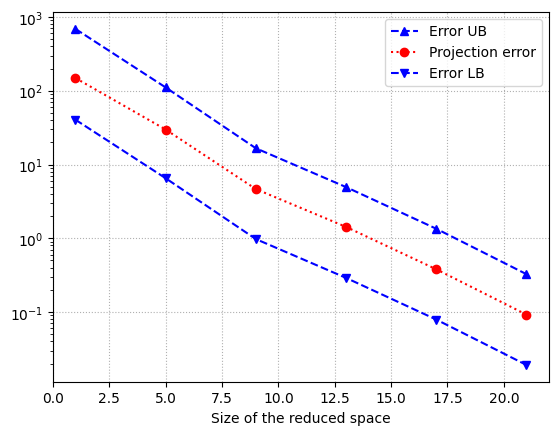

In [20]:
NN = np.array(np.linspace(1,21,6), dtype='int')
projerr = []
est_max = []
est_min = []

for i in NN:
    est_max.append( np.sum(Sv[:-i])/np.min(np.diag(rb.C)) )
    est_min.append( np.sum(Sv[:-i])/np.max(np.diag(rb.C)) )
    rb = podpy.POD(A, inner_product=Xh, N_modes=i, error_type='relative')
    rb.reduce()
    projerr.append( podpy.pod.projection_error(A, rb.rb[:,:i], Xh, error_type='relative')[0] )

plt.figure()
plt.semilogy(NN, est_max, '^b--', label='Error UB')
plt.semilogy(NN, projerr, 'or:',  label='Projection error')
plt.semilogy(NN, est_min, 'vb--', label='Error LB')

plt.xlabel('Size of the reduced space')
plt.ylabel('')
plt.legend()
plt.grid(linestyle=':')
plt.show()

We denote $Y := L^2(\mathcal{P}, V)$ the _model space_ and we introduce 
the norm $\|.\|_Y$ define as
$$
\forall v \in Y, \quad 
\|v\|_{Y} = \left(\int_{\mathcal{P}} \|v(\mu)\|_{V}^2 ~{\rm d}\mu\right)^{1/2} \simeq 
\left( \int_{\mathcal{P}} ~{\rm d}\mu \right)
\left( \frac{1}{K} \sum_{k=1}^{K}\|v(\mu_k)\|_{V}^2 \right)^{1/2}
$$

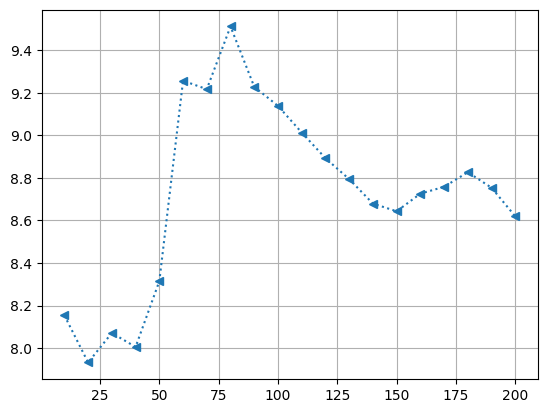

In [21]:
def norm_V(v):
    return np.sqrt( v @ ( Xh @ v ) )

def norm_Y(y, norm_V):
    n = 0
    for i in range(y.shape[1]):
        n += norm_V(y[:,i])**2
    return n/y.shape[1]

norm_Y(A[:,:30], norm_V)

plt.figure()

nY = []
eY = []
nS = []
for i in range(10, Nsnap+10, 10):
    nY.append( norm_Y(A[:,:i], norm_V) )
    eY.append( projection_error(A[:,:i], rb.rb, Xh)[0]/i )
    nS.append( i )

plt.plot(nS, np.array(nY), '<:')

plt.grid()
plt.show()

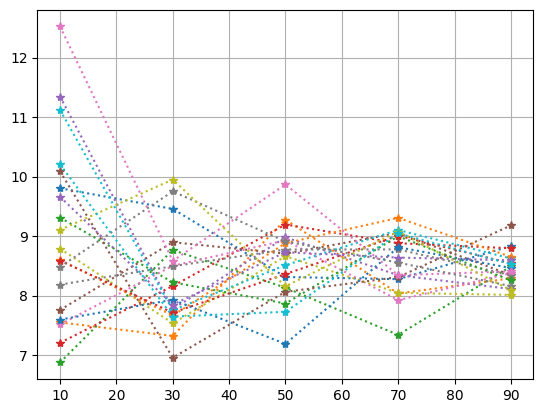

In [22]:

plt.figure()

for j in range(20):
    nY = []
    eY = []
    nS = []
    for i in range(10, int(Nsnap/2)+10, 20):
        I = np.random.permutation(np.arange(Nsnap))[:i]
        nY.append( norm_Y(A[:,I], norm_V) )
        eY.append( projection_error(A[:,I], rb.rb, Xh)[0]/i )
        nS.append( i )

    plt.plot(nS, np.array(nY), '*:')

plt.grid()
plt.show()